In [1]:
import torch
from IPython.display import Audio, display, clear_output
import matplotlib.pyplot as plt
import random
import threading
from librosa.beat import beat_track
import numpy as np
from datasets import load_dataset
from diffusers import DiffusionPipeline, DDIMScheduler, AudioDiffusionPipeline
from diffusers_local import UNet2DModel as UNet2DModel_local

from NetworkBending import NetworkBending
import time  # for safely terminating the loop

# Instantiate NetworkBending object
NB = NetworkBending()

osc_lock = threading.Lock()

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_diffusion = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256")
# apply the custom unet model so we can Networkbend the audio
audio_diffusion.unet = UNet2DModel_local.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="unet", network_bending=NB)

#set the scheduler to DDIM
audio_diffusion.scheduler = DDIMScheduler.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="scheduler")

#load the model to the GPU/CPU
audio_diffusion.to(device)

ds = load_dataset('teticio/audio-diffusion-256')
generator=torch.Generator(device="cpu").manual_seed(42)

KeyboardInterrupt: 

In [2]:
#osc listener
from pythonosc import dispatcher, osc_server

ip="127.0.0.1"
port=9999

d = dispatcher.Dispatcher()
# Map incoming OSC messages to the osc_receive method
d.map("/rotate_x_radian", NB.osc_receive)
d.map("/rotate_y_radian", NB.osc_receive)
d.map("/rotate_z_radian", NB.osc_receive)
d.map("/rotate_x_scaling_factor", NB.osc_receive)
d.map("/rotate_y_scaling_factor", NB.osc_receive)
d.map("/rotate_z_scaling_factor", NB.osc_receive)
d.map("/scale_factor", NB.osc_receive)
d.map("/layer", NB.osc_receive)
d.map("/scale", NB.osc_receive)
d.map("/reflect", NB.osc_receive)
d.map("/erosion", NB.osc_receive)
d.map("/dilation", NB.osc_receive)
d.map("/gradient", NB.osc_receive)
d.map("/sobel", NB.osc_receive)
d.map("/add_rand_rows", NB.osc_receive)
d.map("/normalize", NB.osc_receive)
d.map("/rotate_x", NB.osc_receive)
d.map("/rotate_y", NB.osc_receive)
d.map("/rotate_z", NB.osc_receive)

s = osc_server.ThreadingOSCUDPServer((ip, port), d)

osc_thread = threading.Thread(target=s.serve_forever)
osc_thread.daemon = True # This will allow the main program to exit even if the OSC server is still running
osc_thread.start()
print("OSC server started")

OSC server started


In [3]:
from librosa.beat import beat_track

def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 4) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

In [4]:
#load 20 images from the dataset
images = []

for i in range(10):
    images.append(random.choice(ds['train'])['image'])

images

[<PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>]

In [6]:
#encode images in latent space
encoded_images = []

for i in range(10):
    noise = audio_diffusion.encode([images[i]])
    encoded_images.append(noise)
    

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\danhearn\Documents\GitHub\diffusertrack\diffusers_local\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 50/50 [00:01<00:00, 40.76it/s]


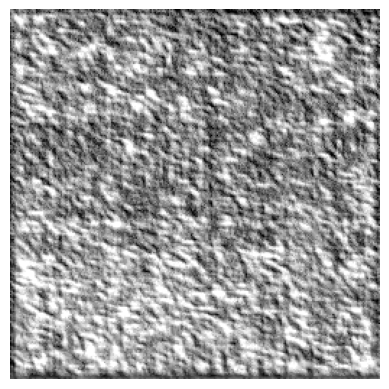

Terminating the loop gracefully.


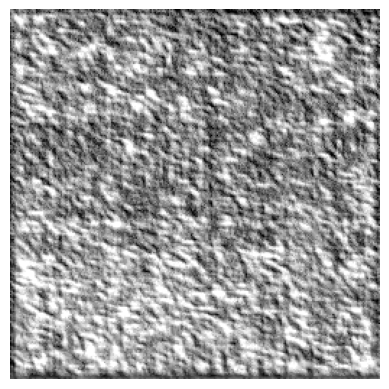

: 

In [8]:
# Main loop for image generation
try:
    while True:
        with osc_lock:  # Ensure that network bending is thread-safe
            alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
            output = audio_diffusion(steps=10,
            noise=AudioDiffusionPipeline.slerp(encoded_images[0], encoded_images[2], alpha),
            generator=generator, eta=0)
            image = output.images[0]
            audio = output.audios[0, 0]
            clear_output(wait=True)
            plt.imshow(image, cmap='gray')   
            plt.axis('off')  # Hide axes
            display(plt.gcf())
            display(Audio(audio, rate=audio_diffusion.mel.get_sample_rate()))
            display(Audio(loop_it(audio, sample_rate=audio_diffusion.mel.get_sample_rate()), rate=audio_diffusion.mel.get_sample_rate()))
            time.sleep(10)


except KeyboardInterrupt:
    s.server_close()
    print("OSC server stopped")